<h1 id="oversampling_on_order_of_3rd_largest_class_for_multiclass_classification_of_accidents">Oversampling on order of 3rd Largest Class for Multi-class Classification of Accident Severity in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f83cf16ff70>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = np.int(os.times()[4])
print(seed)

17608326


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir()) # Print list of contents of current working irectory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.331712044018786 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.322285032016225 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.459637737018056 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical columns.
df_categorical = df_converted.select_dtypes(include="category")

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.170330549008213 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,Clear,Dry,Daylight
5,1,Rear Ended,Clear,Dry,Daylight
6,1,Other,Clear,Wet,Daylight
8,1,Sideswipe,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SEVERITYCODE   171872 non-null  category
 1   COLLISIONTYPE  171872 non-null  category
 2   WEATHER        171872 non-null  category
 3   ROADCOND       171872 non-null  category
 4   LIGHTCOND      171872 non-null  category
dtypes: category(5)
memory usage: 2.1 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.626141435990576 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.078085949993692 seconds.


<h2 id='oversampling_with_replacement'>Oversampling the non-majority classes with Replacement: samples per class = Size of Class '2b'</h2>

In [34]:
sample_size_class_1 = np.int(class_2b_size)
sample_size_class_2 = np.int(class_2b_size)
sample_size_class_2b = np.int(class_2b_size)
sample_size_class_3 = np.int(class_2b_size)

In [35]:
# For each non-minority class, undersample this class by resampling it for a number of samples equal to the size of the minority class.
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1, replace=False, weights=None, axis='index', random_state=seed)
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=False, weights=None, axis='index', random_state=seed)
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=False, weights=None, axis='index', random_state=seed)
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=True, weights=None, axis='index', random_state=seed)

In [36]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [37]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced_oversampled = shuffle(df_balanced_not_shuffled, random_state=seed)

In [38]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_oversampled["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     2941
2b    2941
2     2941
1     2941
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_oversampled["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_balanced_oversampled[["COLLISIONTYPE", "WEATHER", "ROADCOND", "LIGHTCOND"]]

We also define the data for the target variable, SEVERITYCODE, by the array y:

In [41]:
y = df_balanced_oversampled["SEVERITYCODE"].to_numpy()

In [42]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.692755565978587 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [43]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.categories_)

Fitting OneHotEncoder to training data...
Completed in 0.06756757502444088 seconds.
[array(['Angles', 'Cycles', 'Head On', 'Left Turn', 'Other', 'Parked Car',
       'Pedestrian', 'Rear Ended', 'Right Turn', 'Sideswipe'],
      dtype=object), array(['Blowing Sand/Dirt', 'Clear', 'Fog/Smog/Smoke', 'Other',
       'Overcast', 'Partly Cloudy', 'Raining', 'Severe Crosswind',
       'Sleet/Hail/Freezing Rain', 'Snowing'], dtype=object), array(['Dry', 'Ice', 'Other', 'Sand/Mud/Dirt', 'Snow/Slush',
       'Standing Water', 'Wet'], dtype=object), array(['Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dawn', 'Daylight', 'Dusk', 'Other'],
      dtype=object)]


In [44]:
X.shape

(11764, 34)

In [45]:
y.shape

(11764,)

In [46]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.271236551983748 seconds.


<h2 id="logistic_regression_oversampling">Building a Logistic Regression Model through Oversampling<\h2>

In [47]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [48]:
t0 = default_timer()
kfold_cv = KFold(n_splits=10)
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'neg_log_loss','precision_macro', 'recall_macro']
logistic_regression_oversampling_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Logistic regression through oversampling score keys:", sorted(logistic_regression_oversampling_scores.keys()))
print_elapsed_time(t0)

Logistic regression through oversampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 24.33460230898345 seconds.


In [49]:
for key in sorted(logistic_regression_oversampling_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_oversampling_scores[key]), np.std(logistic_regression_oversampling_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_oversampling_scores[key]), sep='')
        print()

fit_time: mean = 4.047104, std = 0.127745
fit_time :[4.06991363 3.70892406 3.98134232 4.09703732 4.16963863 4.16278362
 3.98585796 4.12829804 4.07748532 4.08976245]

score_time: mean = 0.089707, std = 0.003928
score_time :[0.08580232 0.09330344 0.0927794  0.0927999  0.09071898 0.08440471
 0.09176111 0.09147978 0.09230208 0.08171463]

test_f1_macro: mean = 0.455870, std = 0.015428
test_f1_macro :[0.43492138 0.44989372 0.43471959 0.46154549 0.46436455 0.46502537
 0.44911977 0.47013658 0.48537542 0.44359953]

test_neg_log_loss: mean = -1.163747, std = 0.015847
test_neg_log_loss :[-1.18816093 -1.17612257 -1.16396079 -1.1730983  -1.1462075  -1.16133892
 -1.17541881 -1.15531335 -1.13002513 -1.16782006]

test_precision_macro: mean = 0.483687, std = 0.016344
test_precision_macro :[0.46885342 0.4811834  0.45833131 0.48665119 0.4851632  0.49432413
 0.49103875 0.49598295 0.51451277 0.46083164]

test_recall_macro: mean = 0.472257, std = 0.013294
test_recall_macro :[0.45325697 0.47014943 0.45206268

In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 47.094446020026226 seconds.


<h2 id="svm_oversampling">Building a Support Vector Machine through Oversampling without Replacement<\h2>

In [51]:
t0 = default_timer()
kfold_cv = KFold(n_splits=10)
linear_svc_clf = LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=1000)
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
linear_svc_oversampling_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Linear SVM through undersampling score keys:", sorted(linear_svc_oversampling_scores.keys()))
print_elapsed_time(t0)

t0 = default_timer()
kfold_cv = KFold(n_splits=10)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=1000), verbose=True)
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
linear_svc_oversampling_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Linear SVM through oversampling score keys:", sorted(logistic_regression_oversampling_scores.keys()))
print_elapsed_time(t0)

Linear SVM through undersampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 20.070546542003285 seconds.
Linear SVM through oversampling score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 22.74664417299209 seconds.


In [52]:
for key in sorted(linear_svc_oversampling_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_oversampling_scores[key]), np.std(linear_svc_oversampling_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_oversampling_scores[key]), sep='')
        print()

fit_time: mean = 4.408450, std = 0.992397
fit_time :[5.4139905  5.65700555 5.66701651 5.70242238 3.87105012 3.72743893
 3.68318582 3.53303862 3.40928602 3.42006254]

score_time: mean = 0.105456, std = 0.038828
score_time :[0.09380865 0.18909144 0.16395926 0.09729266 0.08637953 0.0738306
 0.12363935 0.08249497 0.07242513 0.07163978]

test_f1_macro: mean = 0.446573, std = 0.016034
test_f1_macro :[0.42367652 0.44665095 0.42571056 0.45258128 0.4447843  0.45422716
 0.43514277 0.46404981 0.47876144 0.44014966]

test_precision_macro: mean = 0.484755, std = 0.017442
test_precision_macro :[0.47148666 0.49054088 0.4576056  0.48534377 0.47405518 0.49645512
 0.48759581 0.49376363 0.52301003 0.46769343]

test_recall_macro: mean = 0.468772, std = 0.012893
test_recall_macro :[0.4493912  0.47240591 0.44937326 0.46480585 0.46484344 0.47878475
 0.47199049 0.48481151 0.48985674 0.46145361]



In [53]:
print_elapsed_time(notebook_start_time)

Elapsed time is 90.2303481969866 seconds.


## Sanity Check: Manually Split the Oversampled Data into Training and Testing Sets

In [54]:
t0 = default_timer()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=np.int(os.times()[4]))

In [56]:
range(len(logistic_regression_oversampling_scores['estimator']))

range(0, 10)

Model 0:
lr_clf mean accuracy = 0.4747131321716957
Jaccard scores by class  [0.3559322  0.30540037 0.17478152 0.39463221]
              precision    recall  f1-score   support

           1   0.633166  0.448399  0.525000       562
           2   0.399027  0.565517  0.467903       580
          2b   0.447284  0.222930  0.297556       628
           3   0.484146  0.680961  0.565930       583

    accuracy                       0.474713      2353
   macro avg   0.490906  0.479452  0.464097      2353
weighted avg   0.488919  0.474713  0.460364      2353



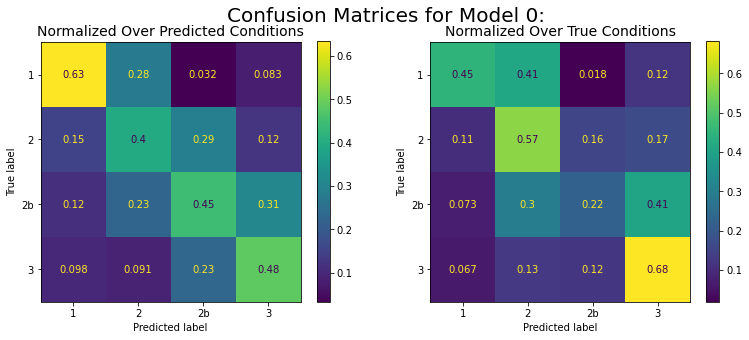

Model 1:
lr_clf mean accuracy = 0.47343816404589883
Jaccard scores by class  [0.35533708 0.30390335 0.1718946  0.39424032]
              precision    recall  f1-score   support

           1   0.627792  0.450178  0.524352       562
           2   0.397327  0.563793  0.466144       580
          2b   0.447712  0.218153  0.293362       628
           3   0.483557  0.680961  0.565527       583

    accuracy                       0.473438      2353
   macro avg   0.489097  0.478271  0.462346      2353
weighted avg   0.487185  0.473438  0.458556      2353



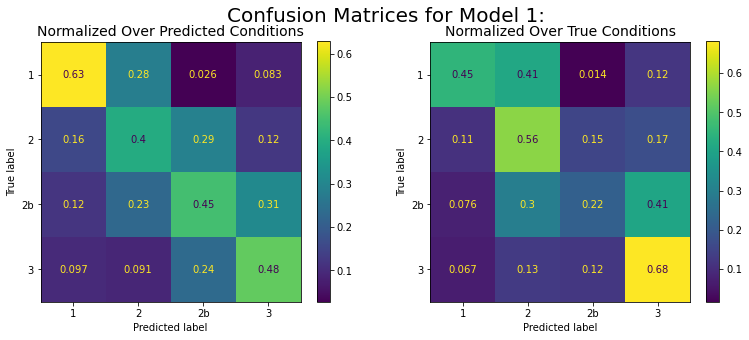

Model 2:
lr_clf mean accuracy = 0.47131321716957075
Jaccard scores by class  [0.35352113 0.30362117 0.1710362  0.39048563]
              precision    recall  f1-score   support

           1   0.629073  0.446619  0.522373       562
           2   0.396845  0.563793  0.465812       580
          2b   0.441935  0.218153  0.292111       628
           3   0.480488  0.675815  0.561654       583

    accuracy                       0.471313      2353
   macro avg   0.487085  0.476095  0.460487      2353
weighted avg   0.485070  0.471313  0.456708      2353



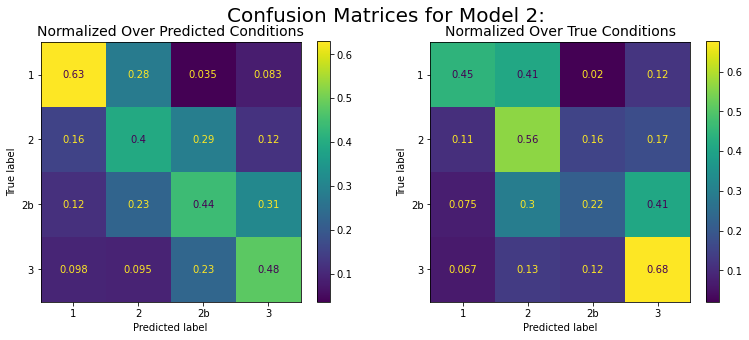

Model 3:
lr_clf mean accuracy = 0.4742881427964301
Jaccard scores by class  [0.35583685 0.30540037 0.17293233 0.39424032]
              precision    recall  f1-score   support

           1   0.629353  0.450178  0.524896       562
           2   0.399027  0.565517  0.467903       580
          2b   0.448052  0.219745  0.294872       628
           3   0.483557  0.680961  0.565527       583

    accuracy                       0.474288      2353
   macro avg   0.489997  0.479100  0.463300      2353
weighted avg   0.488067  0.474288  0.459523      2353



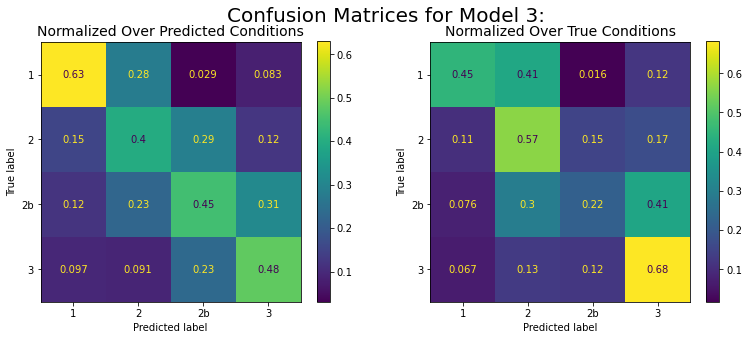

Model 4:
lr_clf mean accuracy = 0.4747131321716957
Jaccard scores by class  [0.35633803 0.30733519 0.17085427 0.39463221]
              precision    recall  f1-score   support

           1   0.630923  0.450178  0.525441       562
           2   0.399758  0.570690  0.470170       580
          2b   0.447368  0.216561  0.291845       628
           3   0.484146  0.680961  0.565930       583

    accuracy                       0.474713      2353
   macro avg   0.490549  0.479597  0.463347      2353
weighted avg   0.488586  0.474713  0.459504      2353



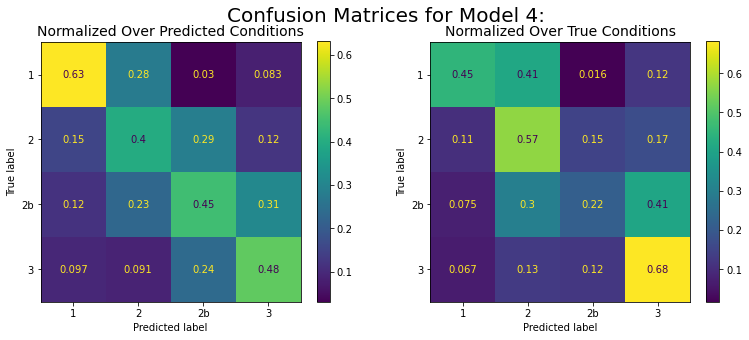

Model 5:
lr_clf mean accuracy = 0.47301317467063325
Jaccard scores by class  [0.35352113 0.30446927 0.17228464 0.39384921]
              precision    recall  f1-score   support

           1   0.629073  0.446619  0.522373       562
           2   0.398295  0.563793  0.466809       580
          2b   0.443730  0.219745  0.293930       628
           3   0.482968  0.680961  0.565125       583

    accuracy                       0.473013      2353
   macro avg   0.488516  0.477780  0.462059      2353
weighted avg   0.486521  0.473013  0.458299      2353



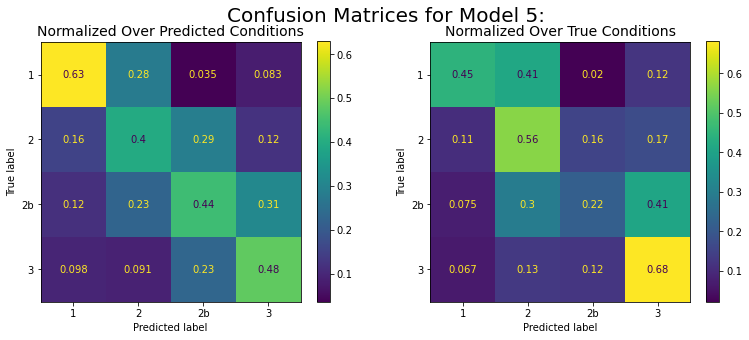

Model 6:
lr_clf mean accuracy = 0.4747131321716957
Jaccard scores by class  [0.35724332 0.30733519 0.16897856 0.39484127]
              precision    recall  f1-score   support

           1   0.630273  0.451957  0.526425       562
           2   0.399758  0.570690  0.470170       580
          2b   0.448161  0.213376  0.289105       628
           3   0.483597  0.682676  0.566145       583

    accuracy                       0.474713      2353
   macro avg   0.490447  0.479675  0.462961      2353
weighted avg   0.488506  0.474713  0.459061      2353



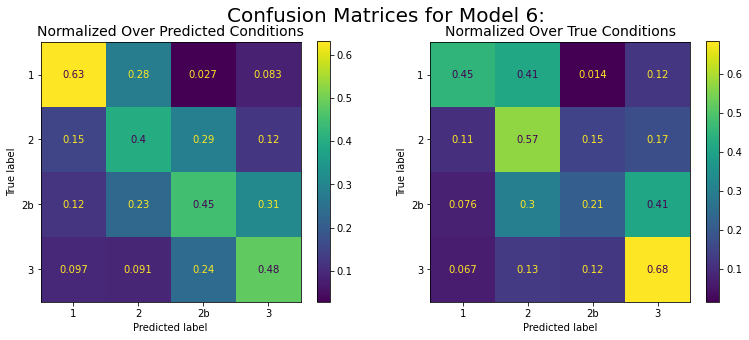

Model 7:
lr_clf mean accuracy = 0.4738631534211645
Jaccard scores by class  [0.35443038 0.305685   0.1725     0.39424032]
              precision    recall  f1-score   support

           1   0.628429  0.448399  0.523364       562
           2   0.399513  0.565517  0.468237       580
          2b   0.445161  0.219745  0.294243       628
           3   0.483557  0.680961  0.565527       583

    accuracy                       0.473863      2353
   macro avg   0.489165  0.478655  0.462843      2353
weighted avg   0.487195  0.473863  0.459071      2353



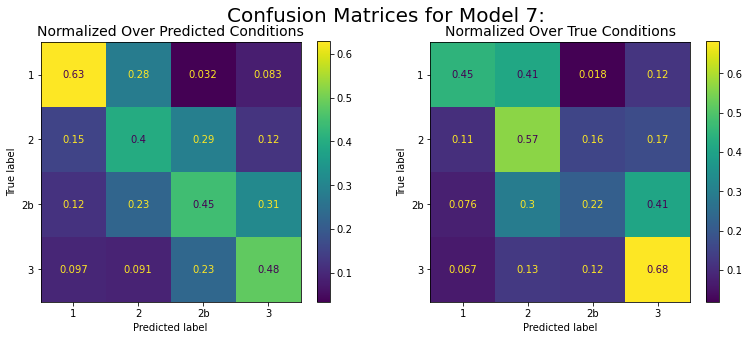

Model 8:
lr_clf mean accuracy = 0.4742881427964301
Jaccard scores by class  [0.35543018 0.30540037 0.17353308 0.39463221]
              precision    recall  f1-score   support

           1   0.631579  0.448399  0.524454       562
           2   0.399027  0.565517  0.467903       580
          2b   0.445513  0.221338  0.295745       628
           3   0.484146  0.680961  0.565930       583

    accuracy                       0.474288      2353
   macro avg   0.490066  0.479053  0.463508      2353
weighted avg   0.488067  0.474288  0.459750      2353



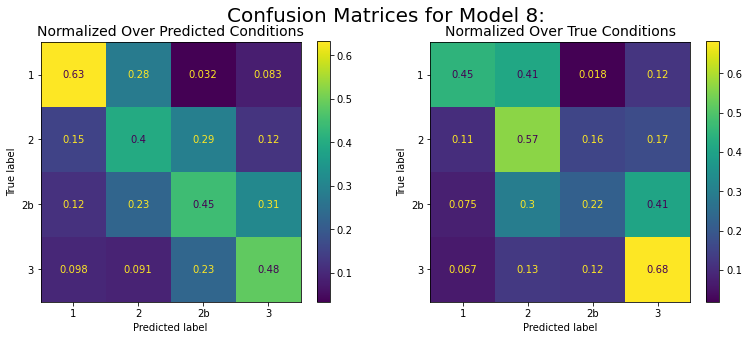

Model 9:
lr_clf mean accuracy = 0.4747131321716957
Jaccard scores by class  [0.35684062 0.30540037 0.17396746 0.39424032]
              precision    recall  f1-score   support

           1   0.632500  0.450178  0.525988       562
           2   0.399027  0.565517  0.467903       580
          2b   0.448387  0.221338  0.296375       628
           3   0.483557  0.680961  0.565527       583

    accuracy                       0.474713      2353
   macro avg   0.490868  0.479498  0.463948      2353
weighted avg   0.488908  0.474713  0.460185      2353



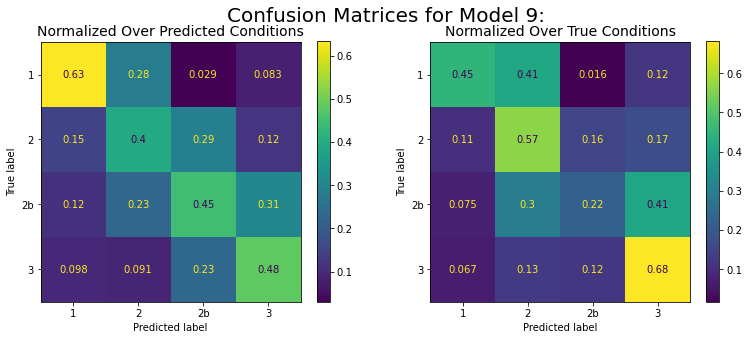

In [57]:
# For each logistic regression classifier in the cross-validation, print the Jaccard score for each class.
for index, lr_clf in zip(range(len(logistic_regression_oversampling_scores['estimator'])), logistic_regression_oversampling_scores['estimator']):
    lr_clf_score = lr_clf.score(X_test, y_test)
    y_test_predicted = lr_clf.predict(X_test)
    lr_clf_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Model %d:' % (index))
    print('lr_clf mean accuracy =', lr_clf_score)
    print('Jaccard scores by class ', lr_clf_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=6))
    
    # Create a figure.
    fig = plt.figure(num=str(index), figsize=(6.4 * 2, 4.8))
    fig.suptitle('Confusion Matrices for Model %d:' % (index), fontsize=20)
    
    ax = plt.subplot(1,2,1)
    ax.set_title("Normalized Over Predicted Conditions", fontsize=14)
    plot_confusion_matrix(lr_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred', ax=ax)
    
    ax = plt.subplot(1,2,2)
    ax.set_title("Normalized Over True Conditions", fontsize=14)
    plot_confusion_matrix(lr_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true', ax=ax)
    
    plt.show()

In [58]:
range(len(linear_svc_oversampling_scores['estimator']))

range(0, 10)

Model 0:
linear_svc_clf mean accuracy = 0.47046323841903953
Jaccard scores by class  [0.34527221 0.30604651 0.15284974 0.39753321]
              precision    recall  f1-score   support

           1   0.639257  0.428826  0.513312       562
           2   0.399272  0.567241  0.468661       580
          2b   0.450382  0.187898  0.265169       628
           3   0.470787  0.718696  0.568907       583

    accuracy                       0.470463      2353
   macro avg   0.489924  0.475665  0.454012      2353
weighted avg   0.487951  0.470463  0.449853      2353



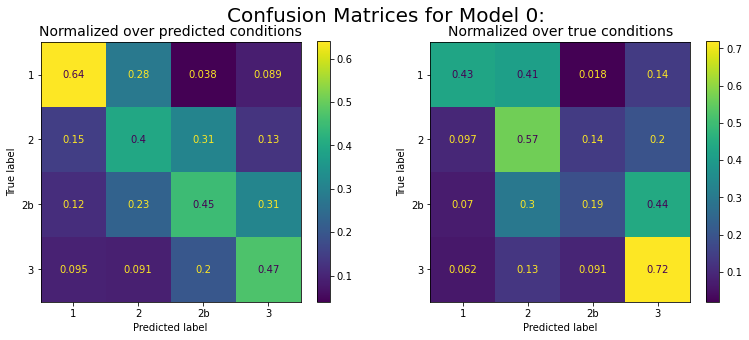

Model 1:
linear_svc_clf mean accuracy = 0.46876328091797703
Jaccard scores by class  [0.34576758 0.30740741 0.15025907 0.39278937]
              precision    recall  f1-score   support

           1   0.640957  0.428826  0.513859       562
           2   0.399038  0.572414  0.470255       580
          2b   0.446154  0.184713  0.261261       628
           3   0.467797  0.710120  0.564033       583

    accuracy                       0.468763      2353
   macro avg   0.488487  0.474018  0.452352      2353
weighted avg   0.486430  0.468763  0.448126      2353



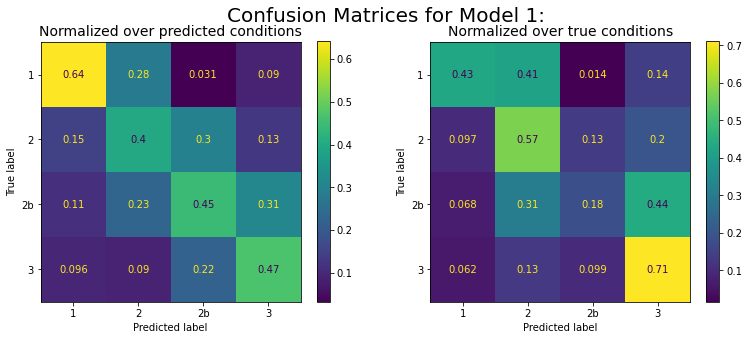

Model 2:
linear_svc_clf mean accuracy = 0.47088822779430517
Jaccard scores by class  [0.34576758 0.30769231 0.15194805 0.3973384 ]
              precision    recall  f1-score   support

           1   0.640957  0.428826  0.513859       562
           2   0.399519  0.572414  0.470588       580
          2b   0.451737  0.186306  0.263811       628
           3   0.471251  0.716981  0.568707       583

    accuracy                       0.470888      2353
   macro avg   0.490866  0.476132  0.454241      2353
weighted avg   0.488895  0.470888  0.450047      2353



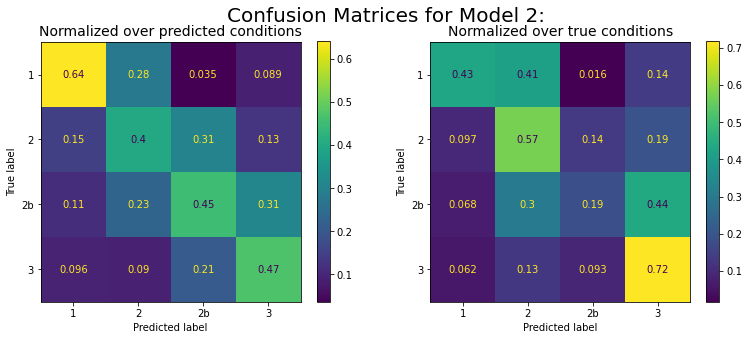

Model 3:
linear_svc_clf mean accuracy = 0.4738631534211645
Jaccard scores by class  [0.35369318 0.3082637  0.15274151 0.39942529]
              precision    recall  f1-score   support

           1   0.636829  0.443060  0.522560       562
           2   0.400483  0.572414  0.471256       580
          2b   0.458824  0.186306  0.265006       628
           3   0.474943  0.715266  0.570842       583

    accuracy                       0.473863      2353
   macro avg   0.492769  0.479261  0.457416      2353
weighted avg   0.490952  0.473863  0.453137      2353



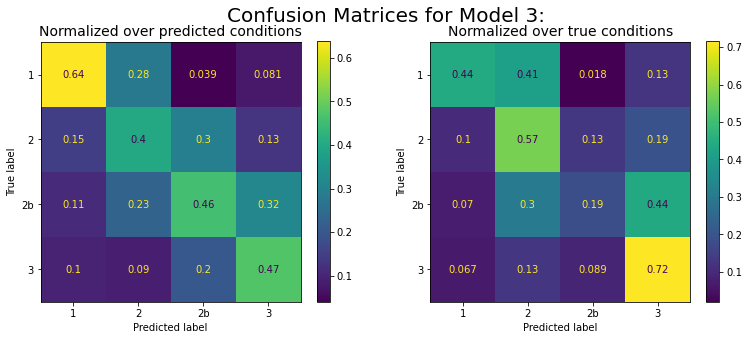

Model 4:
linear_svc_clf mean accuracy = 0.4696132596685083
Jaccard scores by class  [0.34527221 0.30676552 0.14901961 0.39565628]
              precision    recall  f1-score   support

           1   0.639257  0.428826  0.513312       562
           2   0.398795  0.570690  0.469504       580
          2b   0.454183  0.181529  0.259386       628
           3   0.468156  0.718696  0.566982       583

    accuracy                       0.469613      2353
   macro avg   0.490098  0.474935  0.452296      2353
weighted avg   0.488196  0.469613  0.448040      2353



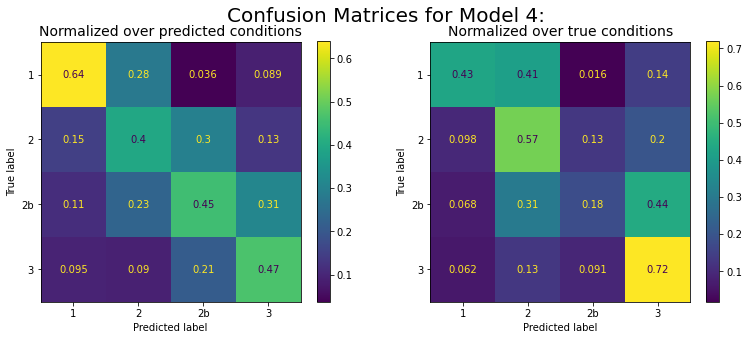

Model 5:
linear_svc_clf mean accuracy = 0.47046323841903953
Jaccard scores by class  [0.34477825 0.30733519 0.15175097 0.3973384 ]
              precision    recall  f1-score   support

           1   0.637566  0.428826  0.512766       562
           2   0.399758  0.570690  0.470170       580
          2b   0.450000  0.186306  0.263514       628
           3   0.471251  0.716981  0.568707       583

    accuracy                       0.470463      2353
   macro avg   0.489644  0.475701  0.453789      2353
weighted avg   0.487680  0.470463  0.449603      2353



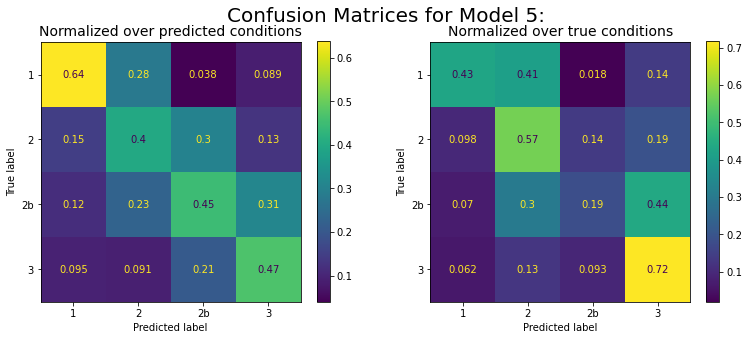

Model 6:
linear_svc_clf mean accuracy = 0.47343816404589883
Jaccard scores by class  [0.35552408 0.30769231 0.14980289 0.39866157]
              precision    recall  f1-score   support

           1   0.635443  0.446619  0.524556       562
           2   0.399519  0.572414  0.470588       580
          2b   0.461538  0.181529  0.260571       628
           3   0.473864  0.715266  0.570062       583

    accuracy                       0.473438      2353
   macro avg   0.492591  0.478957  0.456444      2353
weighted avg   0.490841  0.473438  0.452072      2353



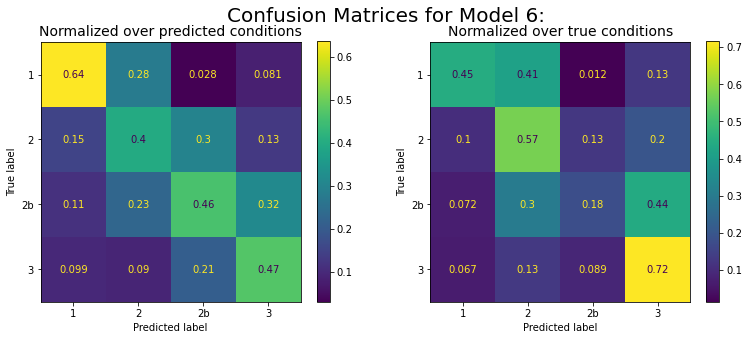

Model 7:
linear_svc_clf mean accuracy = 0.4725881852953676
Jaccard scores by class  [0.35319149 0.30604651 0.15324675 0.39846743]
              precision    recall  f1-score   support

           1   0.635204  0.443060  0.522013       562
           2   0.399272  0.567241  0.468661       580
          2b   0.453846  0.187898  0.265766       628
           3   0.474344  0.713551  0.569863       583

    accuracy                       0.472588      2353
   macro avg   0.490667  0.477938  0.456576      2353
weighted avg   0.488789  0.472588  0.452327      2353



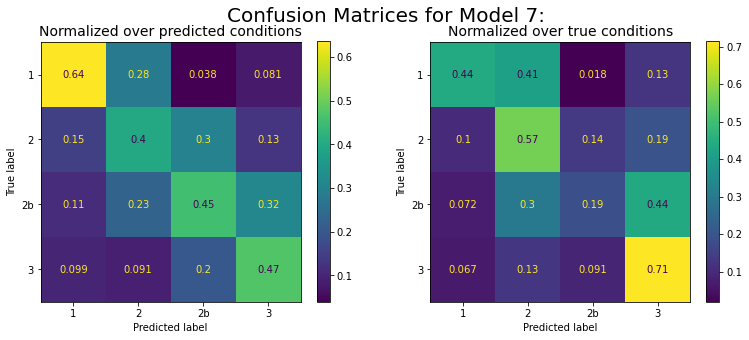

Model 8:
linear_svc_clf mean accuracy = 0.47131321716957075
Jaccard scores by class  [0.34477825 0.30790698 0.15850515 0.39541547]
              precision    recall  f1-score   support

           1   0.637566  0.428826  0.512766       562
           2   0.400726  0.570690  0.470839       580
          2b   0.453875  0.195860  0.273637       628
           3   0.471526  0.710120  0.566735       583

    accuracy                       0.471313      2353
   macro avg   0.490923  0.476374  0.455994      2353
weighted avg   0.489021  0.471313  0.451981      2353



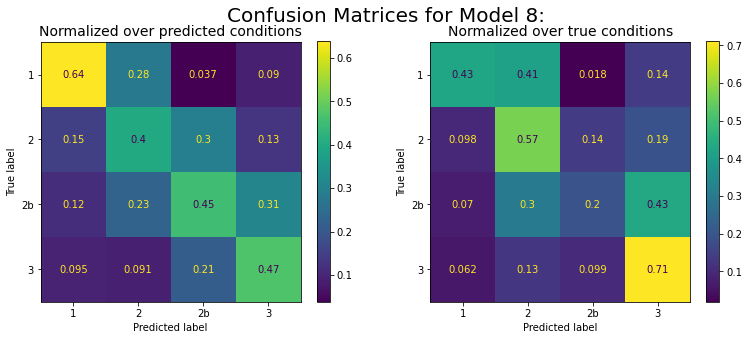

Model 9:
linear_svc_clf mean accuracy = 0.4717382065448364
Jaccard scores by class  [0.34770115 0.30705009 0.15434501 0.39771646]
              precision    recall  f1-score   support

           1   0.643617  0.430605  0.515991       562
           2   0.399276  0.570690  0.469837       580
          2b   0.454198  0.189490  0.267416       628
           3   0.471783  0.716981  0.569095       583

    accuracy                       0.471738      2353
   macro avg   0.492219  0.476942  0.455585      2353
weighted avg   0.490259  0.471738  0.451429      2353



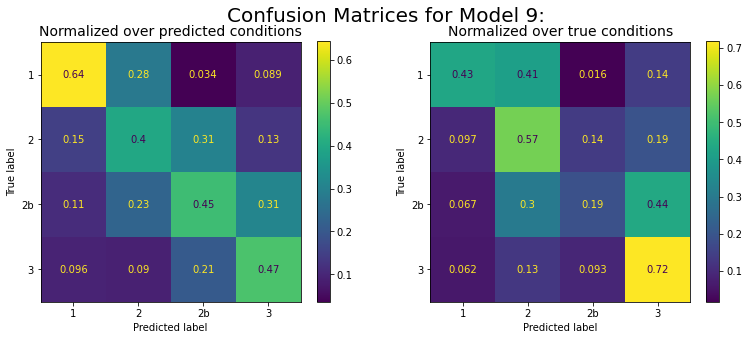

In [59]:
# For each support vector machine classifier in the cross-validation, print the Jaccard score for each class.
for index, linear_svc_clf in zip(range(len(linear_svc_oversampling_scores['estimator'])), linear_svc_oversampling_scores['estimator']):
    linear_svc_score = linear_svc_clf.score(X_test, y_test)
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Model %d:' % (index))
    print('linear_svc_clf mean accuracy =', linear_svc_score)
    print('Jaccard scores by class ', linear_svc_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=6))

    # Create a figure.
    fig = plt.figure(num=str(index), figsize=(6.4 * 2, 4.8))
    fig.suptitle('Confusion Matrices for Model %d:' % (index), fontsize=20)
    
    ax = plt.subplot(1,2,1)
    ax.set_title("Normalized over predicted conditions", fontsize=14)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred', ax=ax)
    
    ax = plt.subplot(1,2,2)
    ax.set_title("Normalized over true conditions", fontsize=14)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true', ax=ax)
    
    plt.show()

In [60]:
print('Graphics and reports generated in %f seconds' % elapsed_time(t0))

Graphics and reports generated in 46.088163 seconds


In [61]:
print_elapsed_time(notebook_start_time)

Elapsed time is 136.6440993740107 seconds.
